# Optimisation of a CNN with a Genetic Algorithm
This section implements a genetic algorithm (GA) to optimize the hyperparameters of a Convolutional Neural Network (CNN). The goal is to find the best combination of hyperparameters (e.g., number of filters, dense units, learning rate, batch size) that maximizes the validation accuracy of the CNN.
## Encoding of chromosomes
Each chromosome represents a potential solution (a set of hyperparameters) and is encoded as a dictionary. The keys of the dictionary correspond to the hyperparameters being optimized, and the values are the specific settings for those hyperparameters. The space of possible values is not continuous, but discrete. They are chosen in a set of allowed values. The parameters, along with their allowed values are : 
* filters: Number of filters in the convolutional layers. Allowed values : [16, 32, 64, 128]
* dense_units: Number of neurons in the fully connected (dense) layer. Allowed values : [32, 64, 128]
* lr: Learning rate for the optimizer. Allowed values : [1e-4, 1e-3, 1e-2, 1e-1]
* batch_size: Number of samples processed in one forward/backward pass during training. Allowed values : [16, 32, 64, 128]
* dropout: Dropout rate. Allowed values : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
> 
There is a total of $4\times 3\times 4 \times 4 \times 6 = 1152$ possible chromosome.
>

Example of a chromosome : {'filters': 32, 'dense_units': 64, 'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}

*It would have also been possible to represent each chromosome as a bit string. However, in Python, dictionnaries are computationnaly more efficient than lists/strings, so I chose not to represent them as bit strings.*

## Crossing function

The chosen crossover strategy is a uniform crossover. For each hyperparameter, the child inherits the value from one of the two parents, chosen at random.

**Example :**

Parent 1 : {'filters': 32, 'dense_units': 64, 'lr': 0.001, 'batch_size': 64}

Parent 2 : {'filters': 64, 'dense_units': 128, 'lr': 0.0001, 'batch_size': 32}

Child : {'filters': 32, 'dense_units': 128, 'lr': 0.001, 'batch_size': 32}

## Mutation function

Each hyperparameter in the chromosome has a small probability (mutation_rate) of being mutated.
If a hyperparameter is selected for mutation, its value is replaced with a new random value from the predefined list of possible values.

*In this notebook, we will use mutation_rate = 0.1*

**Example :**

Original chromosome : {'filters': 32, 'dense_units': 64, 'lr': 0.001, 'batch_size': 64}

Mutated chromosome : {'filters': 64, 'dense_units': 64, 'lr': 0.001, 'batch_size': 128}


In [2]:
################################### IMPORTS ########################################################

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import random
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
################################## DATASET IMPORT AND TRANSFORMATION ##################################

class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None, dataset_type="TRAIN", max_samples=None):
        """
        Args:
            img_dir (str): path to the images folder
            csv_path (str): path to the csv file
            transform (callable, optional): transformation to use on the images
            dataset_type (str): "TRAIN" or "TEST" to load the "train" or "test" dataset
            max_samples (int, optional): max number of sampled to load
        """
        self.img_dir = img_dir
        self.transform = transform
        self.metadata = pd.read_csv(csv_path)
        
        # Filter the data (TRAIN or TEST)
        self.metadata = self.metadata[self.metadata['Dataset_type'] == dataset_type]
        
        # We can limit the number of samples if needed
        if max_samples is not None:
            self.metadata = self.metadata[:max_samples]
        
        # List of images and labels path
        self.image_paths = [os.path.join(img_dir, img_name) for img_name in self.metadata['X_ray_image_name']]
        self.labels = self.metadata['Label'].apply(lambda x: 1 if x == 'Pnemonia' else 0).values  # Exemple de conversion d'étiquettes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convertir en RGB pour les modèles CNN
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensionner les images à 64x64
    transforms.RandomHorizontalFlip(),  # Augmentation de données : retournement horizontal aléatoire
    transforms.ToTensor(),  # Convertir en tenseur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_path = Path('/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset')
training_folder_path = Path('/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train')
testing_folder_path = Path('/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test')
csv_path = "/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv"

train_dataset = ChestXRayDataset(img_dir=training_folder_path,
                                  csv_path=csv_path,
                                  transform=train_transforms,
                                  dataset_type="TRAIN",max_samples=4000)
test_dataset = ChestXRayDataset(img_dir=testing_folder_path,
                                 csv_path=csv_path,
                                 transform=test_transforms,
                                 dataset_type="TEST",max_samples=1000)

In [4]:
################################### CNN and EVALUATION MODEL #################################################

class SimpleCNN(nn.Module):
    def __init__(self, filters=32, dense_units=128, num_classes=2):
        
        super(SimpleCNN, self).__init__()
        
        # Convolution layers
        self.conv1 = nn.Conv2d(3, filters, kernel_size=3, stride=1, padding=1) # 3 inputs (RGB)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size=3, stride=1, padding=1)
        
        # Dense layers
        self.fc1 = nn.Linear(filters * 2 * 16 * 16, dense_units)
        self.fc2 = nn.Linear(dense_units, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


def evaluate_model(hparams, train_dataset, test_dataset, epochs=5):
    
    # Loading of the train and test datas based on the given chromosome's batch_size
    train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False)
    
    # Creation of the model with the hyperparameters of the given chromosome
    model = SimpleCNN(
        filters=hparams['filters'],
        dense_units=hparams['dense_units'],
        num_classes=2  # 2 classes : "Normal" and "Pneumonia"
    )
    
    # Definition of the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])
    
    # Training of the model
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation of the model based on tests
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [5]:
################################## CHROMOSOME DEFINITION ##################################

filters_list = [16, 32, 64, 128]
dense_units_list = [32, 64, 128]
lr_list = [1e-4, 1e-3, 1e-2, 1e-1]
batch_size_list = [16, 32, 64, 128]
dropout_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

def initialize_chromosome(filters_list,dense_units_list,lr_list,batch_size_list,dropout_list):
    chromosome = {
        'filters': random.choice(filters_list),
        'dense_units': random.choice(dense_units_list),
        'lr': random.choice(lr_list),
        'batch_size': random.choice(batch_size_list),
        'dropout': random.choice(dropout_list)
    }
    return chromosome

In [6]:
################################## CROSSOVER AND MUTATION DEFINITION ##################################

def crossover(parent1, parent2):
    child = {}
    for key in parent1:
        # Randomly chose a gene of parent1 or parent2
        child[key] = random.choice([parent1[key], parent2[key]])
    return child

def mutate(chromosome, filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, mutation_rate=0.1):
    mutated_chromosome = chromosome.copy()
    for key in mutated_chromosome:
        if random.random() < mutation_rate:  #We apply a mutation with a mutation_rate probability
            if key == 'filters':
                mutated_chromosome[key] = random.choice(filters_list)
            elif key == 'dense_units':
                mutated_chromosome[key] = random.choice(dense_units_list)
            elif key == 'lr':
                mutated_chromosome[key] = random.choice(lr_list)
            elif key == 'batch_size':
                mutated_chromosome[key] = random.choice(batch_size_list)
            elif key == 'dropout':
                mutated_chromosome[key] = random.choice(dropout_list)
    return mutated_chromosome

In [7]:
################################## GENETIC ALGORITHM ##################################


def genetic_algorithm(train_dataset, test_dataset, filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, population_size=10, generations=5, mutation_rate=0.1):
    """
    Algorithme génétique pour optimiser les hyperparamètres du modèle CNN.
    
    Args:
        train_loader (DataLoader) : DataLoader for the training
        test_loader (DataLoader) : DataLoader for the test
        population_size (int) : Size of the population
        generations (int) : Number of generations
        mutation_rate (float) : Mutation rate
    
    Returns:
        dict: Best chromosome found
    """
    target_score = 0.95
    best_scores = []
    mean_scores = []
    
    # Initialization of the population
    population = [initialize_chromosome(filters_list,dense_units_list,lr_list,batch_size_list,dropout_list) for _ in range(population_size)]
    
    for generation in range(generations):
        print(f"Generation {generation + 1}")
        scores = []
        for chromosome in population:
            # Evaluation of the current chromosome
            accuracy = evaluate_model(chromosome, train_dataset, test_dataset, epochs=5)
            scores.append(accuracy)
            print(f"Chromosome: {chromosome}, Accuracy: {accuracy:.2f}%")
        
        # Selection of the best chromosomes (top 50 %)
        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        top_chromosomes = [population[i] for i in sorted_indices[:population_size // 2]]
        
        # Fill the new population by crossings and mutations
        new_population = top_chromosomes.copy()
        while len(new_population) < population_size:
            parent1, parent2 = random.choices(top_chromosomes, k=2)
            child = crossover(parent1, parent2)
            child = mutate(child,filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, mutation_rate)
            new_population.append(child)
        
        best_scores.append(max(scores))
        mean_scores.append(np.mean(scores))
        population = new_population

        # Stopping criteria
        #if max(scores) >= target_score :
            #break

    plt.figure("Best score for each generation")
    plt.plot(best_scores)
    plt.xlabel("generations")
    plt.ylabel("best scores")
    plt.grid()

    plt.figure("Mean score for each generation")
    plt.plot(mean_scores)
    plt.xlabel("generations")
    plt.ylabel("mean scores")
    plt.grid()
    
    # Return the best chromosome
    best_chromosome = population[sorted_indices[0]]
    return best_chromosome

## Description of the functions :

* initialize_chromosome : returns a chromosome with parameters randomly selected within the available ones.
* crossover : returns a chromosome whose parameters are randomly, uniformly selected among the 2 parents parameters.
* mutation : randomly modifies each gene of a chromosome (with another available parameter) with a probability of mutation_rate.
* evaluate : evaluates a given chromosome (the criterion being the cross entropy loss) and returns a score.

## Summary of the Genetic Algorithm workflow
1. Initialization : Create an initial population of random chromosomes.
2. Evaluation : Train and evaluate a CNN model for each chromosome.
3. Selection : Select the best-performing chromosomes (half of the population).
4. Crossover : Create new chromosomes by combining traits from the selected chromosomes.
5. Mutation : Introduce random changes to the new chromosomes.
6. Repeat : Repeat steps 2–5 for a fixed number of generations or until a stopping condition is met.
7. Output : Return the best set of hyperparameters found.

In [ ]:
################################## USE CASE ##################################

best_hparams = genetic_algorithm(train_dataset, test_dataset,filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, population_size=5, generations=4, mutation_rate=0.1)
print("Meilleurs hyperparamètres trouvés :", round(best_hparams,4))

Generation 1
Chromosome: {'filters': 16, 'dense_units': 64, 'lr': 0.0001, 'batch_size': 16, 'dropout': 0.5}, Accuracy: 80.29%
Chromosome: {'filters': 32, 'dense_units': 128, 'lr': 0.01, 'batch_size': 64, 'dropout': 0.5}, Accuracy: 62.50%
Chromosome: {'filters': 16, 'dense_units': 64, 'lr': 0.1, 'batch_size': 16, 'dropout': 0.3}, Accuracy: 62.50%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.3}, Accuracy: 77.56%
Chromosome: {'filters': 64, 'dense_units': 32, 'lr': 0.1, 'batch_size': 16, 'dropout': 0.2}, Accuracy: 62.50%
Generation 2
Chromosome: {'filters': 16, 'dense_units': 64, 'lr': 0.0001, 'batch_size': 16, 'dropout': 0.5}, Accuracy: 76.44%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.3}, Accuracy: 71.96%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.3}, Accuracy: 78.69%
Chromosome: {'filters': 32, 'dense_units': 64, 'lr': 0.0001, 'batch_size': 16, '

Due tu the limited sessions on kaggle, I couldnt finish to run the algorithm in its entierty in one session. By using the previous generations, I will "manually" re-start the algorithm from where it stopped :

In [ ]:
# Best chromosomes from the 2nd generation
parent1 = {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.3}
parent2 = {'filters': 16, 'dense_units': 64, 'lr': 0.0001, 'batch_size': 16, 'dropout': 0.0}
# Missing chromosome from the 3rd generation
child = crossover(parent1, parent2)
child = mutate(child,filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, 0.1)
child_accuracy = evaluate_model(child, train_dataset, test_dataset, epochs=5)

In [8]:
print(f"Chromosome: {child}, Accuracy: {child_accuracy:.2f}%")

Chromosome: {'filters': 16, 'dense_units': 64, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.0}, Accuracy: 74.04%


Generation 4
Chromosome: {'filters': 16, 'dense_units': 64, 'lr': 0.0001, 'batch_size': 32, 'dropout': 0.0}, Accuracy: 73.72%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.3}, Accuracy: 76.76%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.0001, 'batch_size': 32, 'dropout': 0.0}, Accuracy: 75.00%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.0}, Accuracy: 75.32%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.0}, Accuracy: 75.80%
Generation 5
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.3}, Accuracy: 72.92%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.0}, Accuracy: 75.96%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.1, 'batch_size': 16, 'dropout': 0.3}, Accuracy: 62.50%
Chromosome: {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 

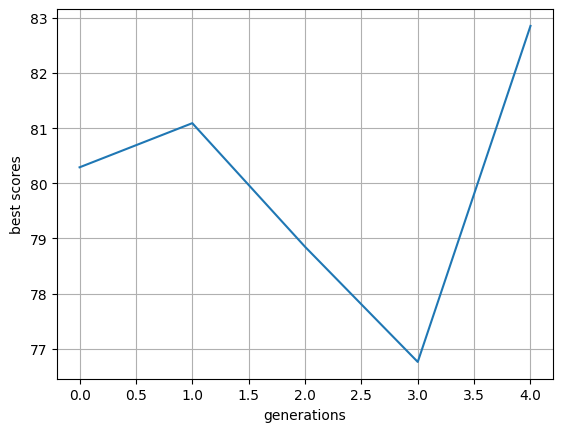

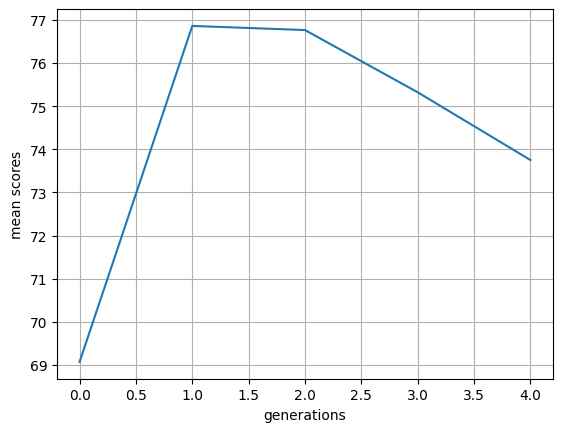

In [10]:
best_scores = [80.29, 81.09, 78.85]
mean_scores = [np.mean([80.29,62.50,62.50,77.56,62.50]),np.mean([76.44,71.96,78.69,76.12,81.09]),np.mean([75.48, 76.76, 78.69, 78.85,74.04 ])]
generations = [4, 5]
population_size = 5
mutation_rate = 0.1
# Generation of the 4th generation, based on the best 3rd generation parents
gen3_parent1 = {'filters': 16, 'dense_units': 64, 'lr': 0.0001, 'batch_size': 32, 'dropout': 0.0}
gen3_parent2 = {'filters': 16, 'dense_units': 32, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.3}
child3 = crossover(gen3_parent1, gen3_parent2)
child3 = mutate(child3,filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, 0.1)
child4 = crossover(gen3_parent1, gen3_parent2)
child4 = mutate(child4,filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, 0.1)
child5 = crossover(gen3_parent1, gen3_parent2)
child5 = mutate(child5,filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, 0.1)
population = [gen3_parent1, gen3_parent2, child3, child4, child5]

# We finish to run the algorithm, for the 4th and 5th generation
for generation in generations:
    print(f"Generation {generation}")
    scores = []
    for chromosome in population:
        # Evaluation of the current chromosome
        accuracy = evaluate_model(chromosome, train_dataset, test_dataset, epochs=5)
        scores.append(accuracy)
        print(f"Chromosome: {chromosome}, Accuracy: {accuracy:.2f}%")
        
    # Selection of the best chromosomes (top 50 %)
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    top_chromosomes = [population[i] for i in sorted_indices[:population_size // 2]]
        
    # Fill the new population by crossings and mutations
    new_population = top_chromosomes.copy()
    while len(new_population) < population_size:
        parent1, parent2 = random.choices(top_chromosomes, k=2)
        child = crossover(parent1, parent2)
        child = mutate(child,filters_list,dense_units_list,lr_list,batch_size_list,dropout_list, mutation_rate)
        new_population.append(child)
        
    best_scores.append(max(scores))
    mean_scores.append(np.mean(scores))
    population = new_population

    # Stopping criteria
    #if max(scores) >= target_score :
        #break

plt.figure("Best score for each generation")
plt.plot(best_scores)
plt.xlabel("generations")
plt.ylabel("best scores")
plt.grid()

plt.figure("Mean score for each generation")
plt.plot(mean_scores)
plt.xlabel("generations")
plt.ylabel("mean scores")
plt.grid()

In [11]:
print(mean_scores)
print(best_scores)

[69.07000000000001, 76.85999999999999, 76.764, 75.32051282051282, 73.75]
[80.29, 81.09, 78.85, 76.76282051282051, 82.8525641025641]


## Conclusion
One notable observation is that evaluating the same chromosome multiple times can yield different results due to the inherent randomness in the training process (e.g., weight initialization, data shuffling...). This variability introduces an additional layer of complexity to the search process, making it more challenging to reliably identify the best-performing hyperparameters.


Overall, the population's mean accuracy tends to improve and the best accuracy improved, reflecting the effectiveness of the genetic algorithm in exploring and refining hyperparameter combinations. However, this trend does not always means that they are increasing functions, as the scores can fluctuate between generations.

Additionally, it is possible that the mutation rate was set too low. In some cases, when both parents shared the same value for a particular hyperparameter, that value could become "stuck" in the population, limiting the algorithm's ability to explore alternative values. A higher mutation rate might help overcome this issue by introducing more diversity and preventing the algorithm from converging prematurely to suboptimal solutions.

One significant challenge encountered during this optimization process was the computational cost. Running the algorithm was extremely time-consuming, with each generation taking approximately one hour to complete. This highlights the trade-off between the thoroughness of the search and the practical constraints of computational resources. Future work could explore strategies to reduce the runtime, such as parallelizing evaluations, using smaller subsets of data for initial exploration, or leveraging more efficient model architectures.